# Data

Goal: Predict the amount of energy consumed by a building with solar panel!

- **Month**: The month of the year when the data was recorded.
- **Hour**: The hour of the day when the data was recorded.
- **DayOfWeek**: The day of the week when the data was recorded.
- **Holiday**: Indicates whether the day was a holiday (Yes/No).
- **Temperature**: The average daily temperature in Celsius
- **Humidity**: The average daily humidity level (%).
- **SquareFootage**: The area of the building being monitored in square meters.
- **Occupancy**: The total number of people occupying the building.
- **HVACUsage**: Indicates whether the HVAC system was in use (On/Off).
- **LightingUsage**: Indicates whether the lighting system was in use (On/Off).
- **RenewableEnergy**: The amount of renewable energy generated at the time of data collection.
- **EnergyConsumption**: The amount of energy consumed at the time of data collection.

# Import Library

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [52]:
df = pd.read_parquet("dataset_1A.parquet")
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


In [53]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB
None


In [54]:
print(df.describe())

              Hour  Temperature     Humidity  SquareFootage    Occupancy  \
count  1232.000000  1232.000000  1232.000000    1232.000000  1232.000000   
mean     11.192370    24.887052    45.749180    1511.599284     4.607143   
std       6.941171     3.045583     9.083050     297.219745     2.905757   
min       0.000000    20.007565    30.015975    1000.512661    -5.000000   
25%       5.000000    22.385226    38.022993    1258.359797     2.000000   
50%      11.000000    24.716913    46.152351    1504.978812     5.000000   
75%      17.000000    27.305707    53.317264    1773.253483     7.000000   
max      23.000000    29.998671    59.969085    1999.982252     9.000000   

       RenewableEnergy  
count      1232.000000  
mean         15.339704  
std           9.225973  
min           0.006642  
25%           7.638064  
50%          15.601873  
75%          23.118105  
max          29.965327  


### Null and Duplicates Values

In [55]:
df.duplicated().sum()

0

In [56]:
df.isnull().sum()

Month                0
Hour                 0
DayOfWeek            0
Holiday              0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
EnergyConsumption    0
dtype: int64

There is no duplicated and null values, but we need to further investigate if there is any unusual value.

### Prepare Column & Variable

Fix some unsual value
- Month : Sep, September into 9, July into 7
- EnergyConsumption : delete value "nan"
- Occupancy : delete value "-5"

In [57]:
df['Month'] = df['Month'].replace('Sep', 9)
df['Month'] = df['Month'].replace('July', 7)
df['Month'] = df['Month'].replace('September', 9)
df = df[df["EnergyConsumption"] != "nan"]
df = df[df["Occupancy"] != -5]

Fix data type

In [58]:
df['Month'] = df['Month'].astype(int)
df['EnergyConsumption'] = df['EnergyConsumption'].astype(float)

In [59]:
cat_cols = []
num_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']
Numeric: ['Month', 'Hour', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']


In [61]:
df[num_cols].head()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
0,8,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358
1,1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177
2,1,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098
3,7,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179
4,10,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272


In [62]:
df[cat_cols].head()

,DayOfWeek,Holiday,HVACUsage,LightingUsage
0,Sunday,Yes,On,Off
1,Wednesday,No,On,Off
2,Sunday,Yes,Off,On
3,Wednesday,Yes,Off,On
4,Saturday,No,Off,Off


# <span style="color:red">EDA</span>

### Unique Categorical Values

In [63]:
for col in cat_cols:
  print(df[col].value_counts(), '\n')

DayOfWeek
Sunday       192
Saturday     183
Thursday     181
Friday       169
Tuesday      168
Monday       168
Wednesday    167
Name: count, dtype: int64 

Holiday
No     672
Yes    556
Name: count, dtype: int64 

HVACUsage
Off    628
On     600
Name: count, dtype: int64 

LightingUsage
On     617
Off    611
Name: count, dtype: int64 



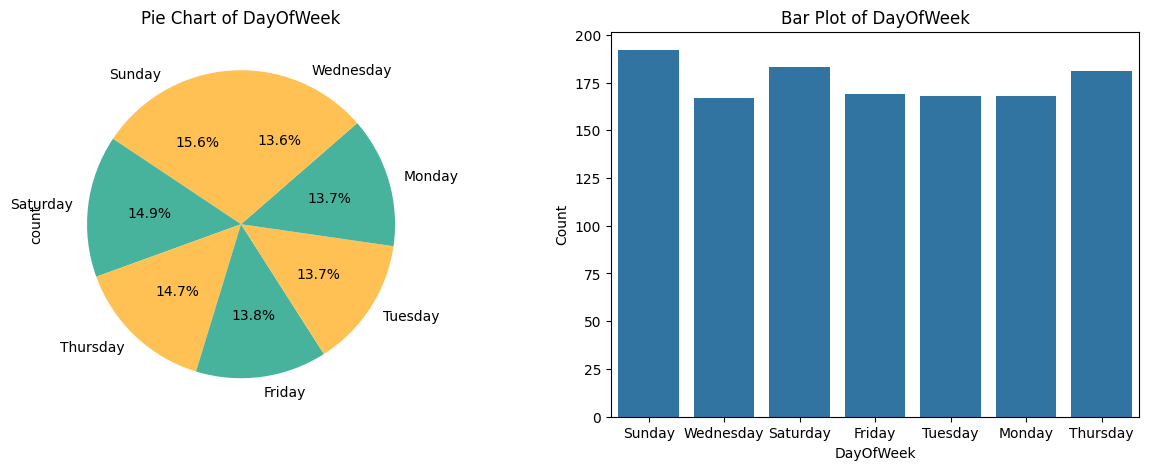

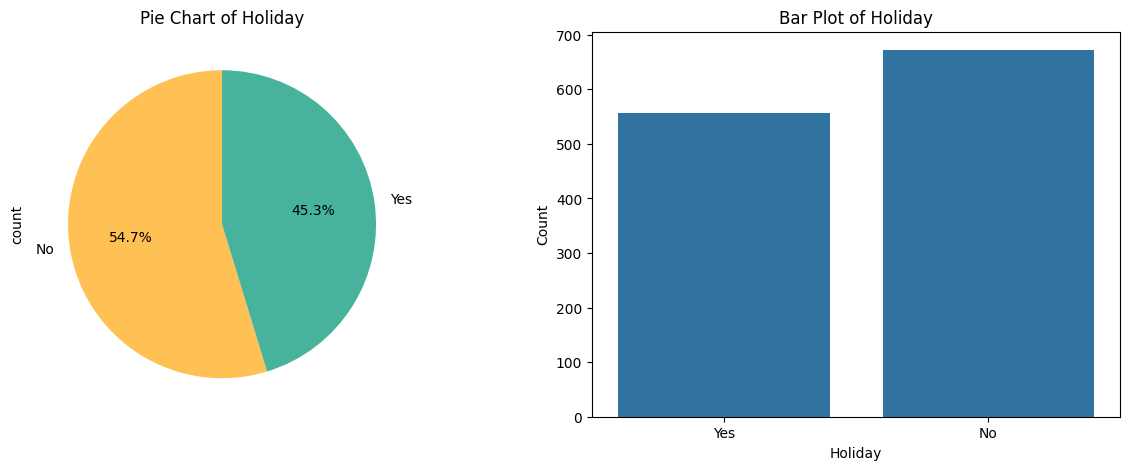

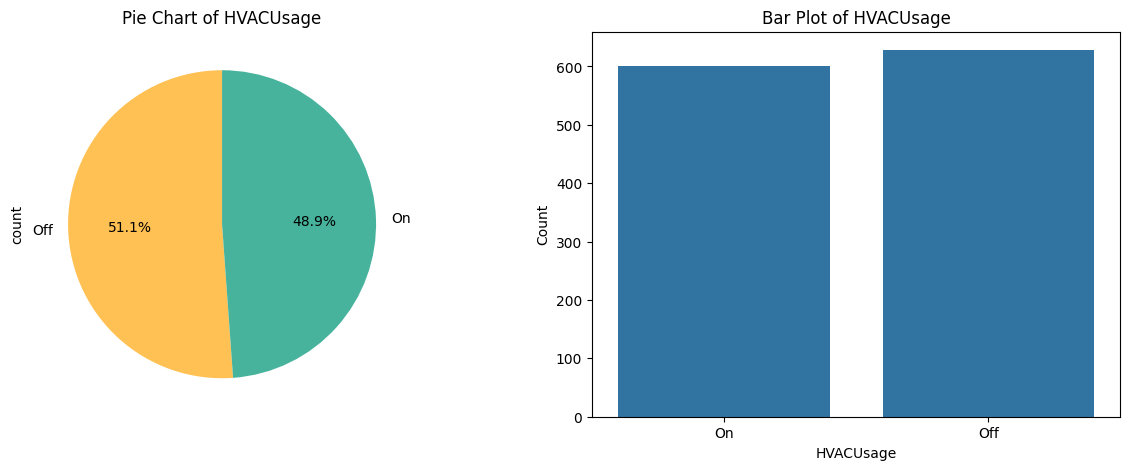

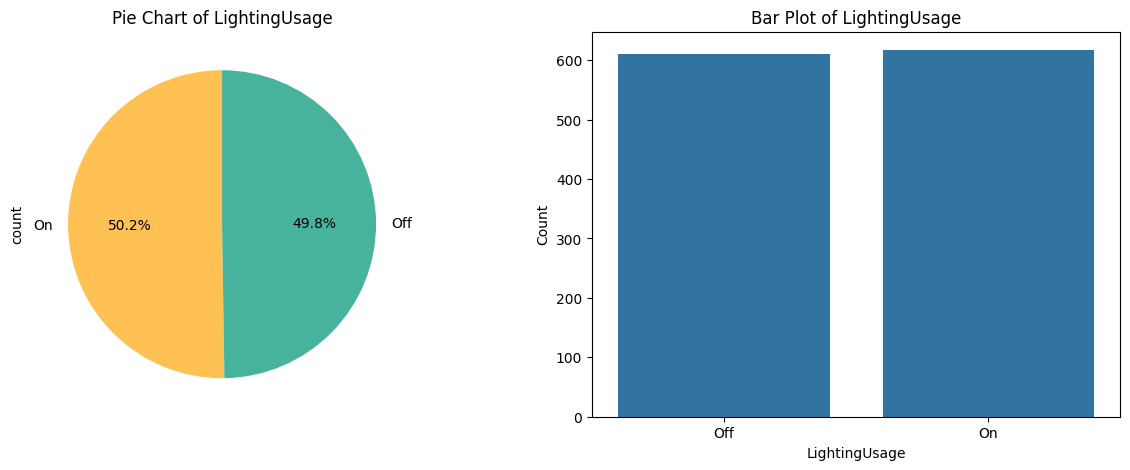

In [65]:
def binary_graph(df, columns):
    for col in columns:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#FFC154', '#47B39C'])
        plt.title(f'Pie Chart of {col}')

        plt.subplot(1, 2, 2)
        sns.countplot(data=df, x=col)
        plt.title(f'Bar Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')

binary_graph(df[cat_cols], cat_cols)

Data in the categorical value is spread pretty evenly

### Distribution & Outliers

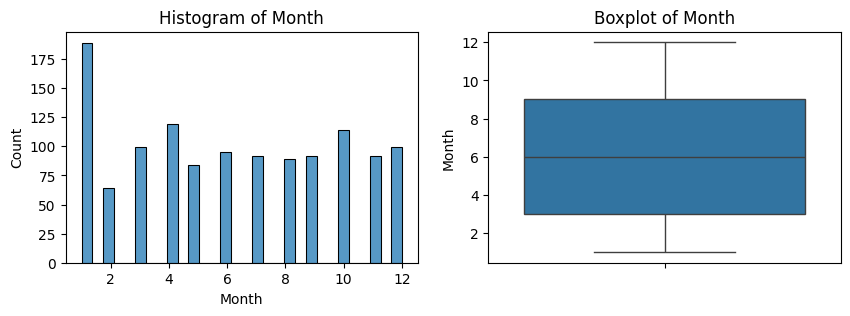

Month - Skewness: 0.04691082500783729
Month - Kurtosis: -1.2855893309138011


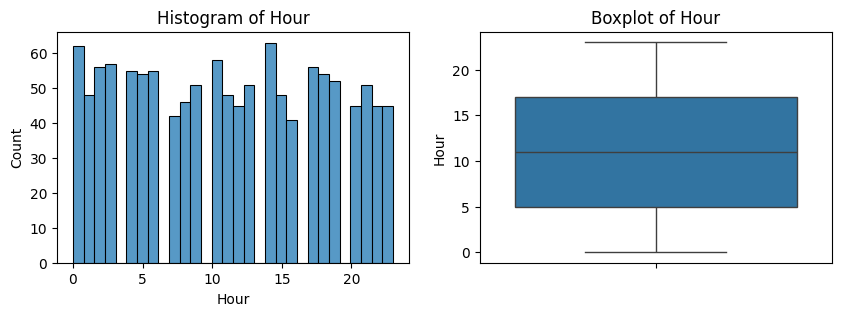

Hour - Skewness: 0.029169649459106533
Hour - Kurtosis: -1.2144244656020857


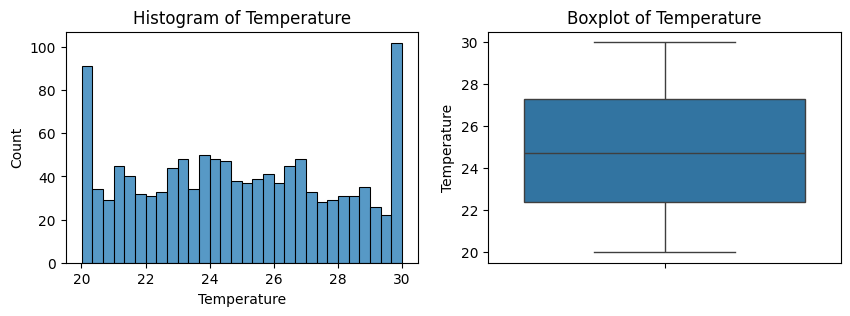

Temperature - Skewness: 0.07763737212064575
Temperature - Kurtosis: -1.1127675243864208


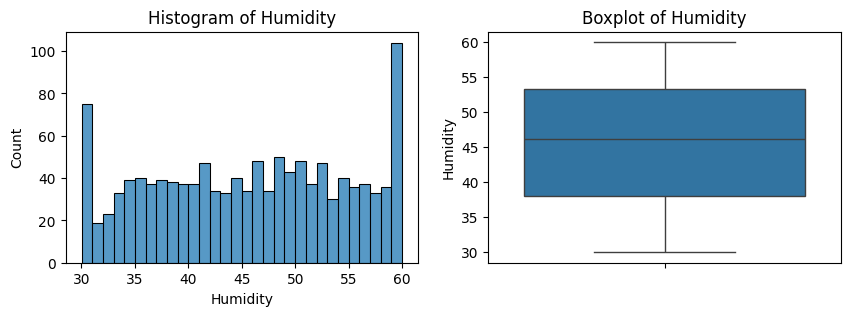

Humidity - Skewness: -0.0716965388571922
Humidity - Kurtosis: -1.1488598151639784


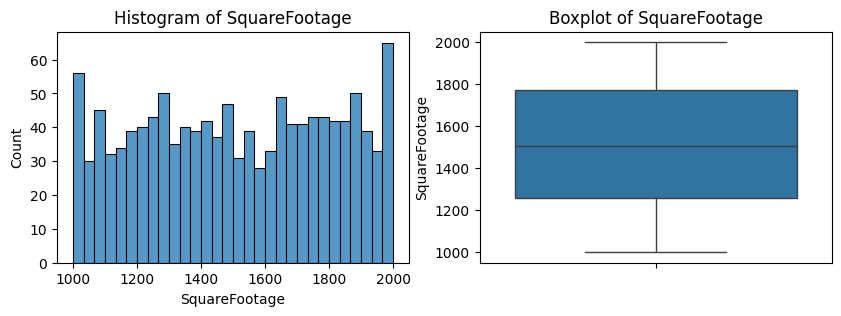

SquareFootage - Skewness: -0.03304132599645417
SquareFootage - Kurtosis: -1.2066642620735768


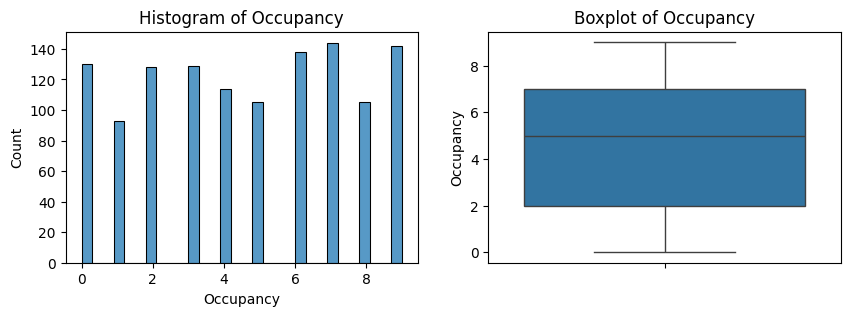

Occupancy - Skewness: -0.059093911221706694
Occupancy - Kurtosis: -1.2169449855650338


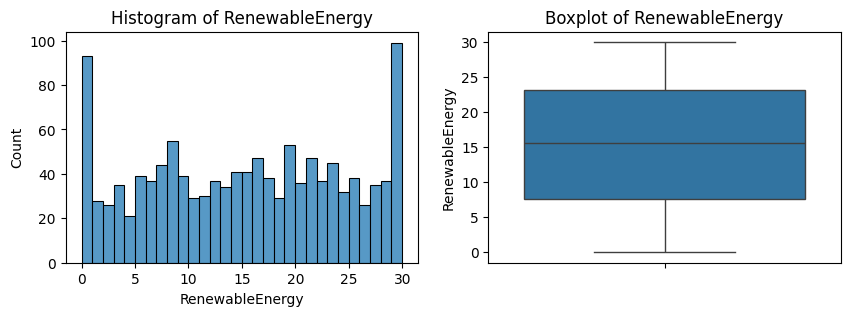

RenewableEnergy - Skewness: -0.04622614705118566
RenewableEnergy - Kurtosis: -1.1673890972329062


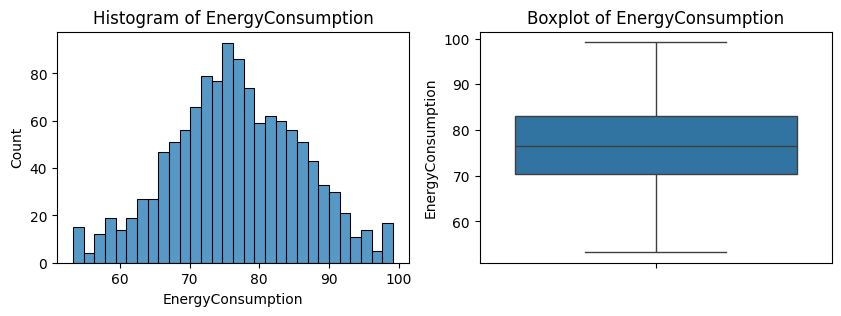

EnergyConsumption - Skewness: -0.02922942490964104
EnergyConsumption - Kurtosis: -0.2391794666229452


In [64]:
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=dataframe[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')

check_distribution_outliers(df[num_cols], num_cols)

In [66]:
for i in num_cols:
    print(i, shapiro(df[i]), '\n')

Month ShapiroResult(statistic=0.9266449853103079, pvalue=5.004484222152986e-24) 

Hour ShapiroResult(statistic=0.9496811172571605, pvalue=4.501031567853742e-20) 

Temperature ShapiroResult(statistic=0.9543233240477303, pvalue=4.048043364481614e-19) 

Humidity ShapiroResult(statistic=0.9538395268353691, pvalue=3.196123963003119e-19) 

SquareFootage ShapiroResult(statistic=0.9534009836168733, pvalue=2.5838864617838885e-19) 

Occupancy ShapiroResult(statistic=0.9337212723233281, pvalue=6.323004451686598e-23) 

RenewableEnergy ShapiroResult(statistic=0.951460641513134, pvalue=1.0258646071060705e-19) 

EnergyConsumption ShapiroResult(statistic=0.9962642274739976, pvalue=0.004563551596922868) 



From shapiro test we can see that all of numerical columns data has p-value < 0.05 which means there is no normally distributed data. We can use RobustScaler to scale the data. 

# <span style="color:red">Encoding</span>

In [67]:
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.057358
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.889177
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.202098
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.439179
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.902272


Label Encoder were used on columns Holiday, HVACUsage and LightingUsage because the value are binary (On/Off)

In [68]:
label_encoder = LabelEncoder()
label_cols = ['Holiday', 'HVACUsage', 'LightingUsage']
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

OneHotEncoder were used on column DayOfWeek because days like Monday, Tuesday, ..., Sunday don’t have a meaningful "order"

In [69]:
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oh_encoded = ohe_enc.fit_transform(df[['DayOfWeek']])
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['DayOfWeek']))
one_hot_df.index = df.index
df = pd.concat([df.drop(columns=['DayOfWeek']), one_hot_df.astype('int')], axis=1)

# Split Data 

Split data into 70% train, 20% test and 10% validation

In [70]:
x = df.drop(columns=['EnergyConsumption']) 
y = df['EnergyConsumption']

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=2/3, random_state=42)


In [72]:
num_cols.remove('EnergyConsumption')

# Scaling

In [73]:
scaler = RobustScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler.transform(y_val.values.reshape(-1,1))
y_test = scaler.transform(y_test.values.reshape(-1,1))

Robust Scaler were used due to its data is not normally distributed.

# Modelling

### Preparation

In [74]:
callback_model = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

Callback is used to stop training when validation loss stops improving. Therefore optimize the training process without manually checking every step.

### Sequential Model

In [136]:
n = x_train.shape[1]

seq_model = keras.Sequential([
    layers.Dense(n * 2, activation='relu', input_shape=(n,)),  
    layers.Dense(n * 2, activation='relu'),
    layers.Dense(n * 2, activation='relu'),
    layers.Dense(1)
])


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [137]:
seq_model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse', RootMeanSquaredError(name='rmse')])

seq_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 34)             │           612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 34)             │         1,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 34)             │         1,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,027 (11.82 KB)

 Trainable params: 3,027 (11.82 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
history_seq = seq_model.fit(x_train, 
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=100,
                            batch_size=32,
                            callbacks=callback_model,
                            verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5926 - mae: 0.6227 - mse: 0.5926 - rmse: 0.7675 - val_loss: 0.4947 - val_mae: 0.5531 - val_mse: 0.4947 - val_rmse: 0.7034 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4794 - mae: 0.5604 - mse: 0.4794 - rmse: 0.6923 - val_loss: 0.4340 - val_mae: 0.5191 - val_mse: 0.4340 - val_rmse: 0.6588 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4122 - mae: 0.5179 - mse: 0.4122 - rmse: 0.6414 - val_loss: 0.3914 - val_mae: 0.4982 - val_mse: 0.3914 - val_rmse: 0.6256 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3599 - mae: 0.4770 - mse: 0.3599 - rmse: 0.5998 - val_loss: 0.3825 - val_mae: 0.4925 - val_mse: 0.3825 - val_rmse: 0.6184 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3818 - mae: 0.4946 - mse: 0.3818 - rmse: 0.6175 - val_loss: 0.3785 - val_mae: 0.4948 - val_mse: 0.3785 - val_r

### Functional Model

In [195]:
inputs = Input(shape=(n,))
x = Dense(4 * n, activation='relu')(inputs) 
x = Dense(4 * n, activation='relu')(inputs)       
x = Dense(4 * n, activation='relu')(x)            
x = Dense(4 * n, activation='relu')(x)           
outputs = Dense(1)(x)    

func_model = Model(inputs=inputs, outputs=outputs)
func_model.compile(optimizer='adam', loss='mse', metrics=['mae','mse', RootMeanSquaredError(name='rmse')])
print("\nFunctional Model Summary:")
func_model.summary()


Functional Model Summary:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 68)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 68)             │         4,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 68)             │         4,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            69 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,677 (41.71 KB)

 Trainable params: 10,677 (41.71 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
history_func = func_model.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=100,
                              batch_size=32,
                              callbacks=callback_model,
                              verbose=1)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4682 - mae: 0.5454 - mse: 0.4682 - rmse: 0.6838 - val_loss: 0.3840 - val_mae: 0.4936 - val_mse: 0.3840 - val_rmse: 0.6197 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3649 - mae: 0.4834 - mse: 0.3649 - rmse: 0.6040 - val_loss: 0.3636 - val_mae: 0.4732 - val_mse: 0.3636 - val_rmse: 0.6030 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3288 - mae: 0.4557 - mse: 0.3288 - rmse: 0.5732 - val_loss: 0.3616 - val_mae: 0.4739 - val_mse: 0.3616 - val_rmse: 0.6013 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3166 - mae: 0.4519 - mse: 0.3166 - rmse: 0.5624 - val_loss: 0.3671 - val_mae: 0.4758 - val_mse: 0.3671 - val_rmse: 0.6059 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3118 - mae: 0.4511 - mse: 0.3118 - rmse: 0.5583 - val_loss: 0.3670 - val_mae: 0.4814 - val_mse: 0.3670 - val_r

# Modification of Both Model

### Modification Sequential Model

In [212]:
mod_seq_model = Sequential([
    layers.Dense(4*n, activation='relu', input_shape=(n,)),                                   
    Dropout(0.2),                                          
    layers.Dense(4*n, activation='relu'),
    Dropout(0.2),                                           
    layers.Dense(4*n, activation='relu'),
    Dropout(0.2),  
    layers.Dense(4*n, activation='relu'),
    Dropout(0.2),                       
    layers.Dense(1)                                                
])


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [213]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)                     
mod_seq_model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse', RootMeanSquaredError(name='rmse')])
mod_seq_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_94 (Dense)                │ (None, 68)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 68)             │         4,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 68)             │         4,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 68)             │         4,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            69 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,369 (60.04 KB)

 Trainable params: 15,369 (60.04 KB)

 Non-trainable params: 0 (0.00 B)

In [214]:
history_seq_mod = mod_seq_model.fit(x_train, y_train,
                                    validation_data=(x_val, y_val),
                                    epochs=100,
                                    batch_size=32,
                                    callbacks = callback_model)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5134 - mae: 0.5726 - mse: 0.5134 - rmse: 0.7164 - val_loss: 0.4606 - val_mae: 0.5281 - val_mse: 0.4606 - val_rmse: 0.6787 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4406 - mae: 0.5267 - mse: 0.4406 - rmse: 0.6634 - val_loss: 0.3859 - val_mae: 0.4947 - val_mse: 0.3859 - val_rmse: 0.6212 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4320 - mae: 0.5228 - mse: 0.4320 - rmse: 0.6572 - val_loss: 0.3727 - val_mae: 0.4881 - val_mse: 0.3727 - val_rmse: 0.6105 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4122 - mae: 0.5116 - mse: 0.4122 - rmse: 0.6416 - val_loss: 0.3737 - val_mae: 0.4887 - val_mse: 0.3737 - val_rmse: 0.6113 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3999 - mae: 0.4986 - mse: 0.3999 - rmse: 0.6322 - val_loss: 0.3688 - val_mae: 0.4831 - val_mse: 0.3688 - val_r

### Modifikasi Functional Model

In [215]:
inputs = Input(shape=(n,))
x = Dense(4*n, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(5*n, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(5*n, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4*n, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

mod_func_model = Model(inputs=inputs, outputs=outputs)

In [216]:
mod_func_model.compile(optimizer=Adam(),loss='mse',metrics=['mae','mse', RootMeanSquaredError(name='rmse')])

In [217]:
print("\nModified Functional Model Summary:")
mod_func_model.summary()


Modified Functional Model Summary:


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 68)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 85)             │         5,865 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 85)             │         7,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 68)             │         5,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            69 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,316 (79.36 KB)

 Trainable params: 20,316 (79.36 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
history_func_mod = mod_func_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks = callback_model,
    verbose = 1,
    batch_size=32
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5530 - mae: 0.5879 - mse: 0.5530 - rmse: 0.7432 - val_loss: 0.4333 - val_mae: 0.5168 - val_mse: 0.4333 - val_rmse: 0.6583 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4456 - mae: 0.5403 - mse: 0.4456 - rmse: 0.6675 - val_loss: 0.3908 - val_mae: 0.4840 - val_mse: 0.3908 - val_rmse: 0.6251 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4612 - mae: 0.5378 - mse: 0.4612 - rmse: 0.6787 - val_loss: 0.3737 - val_mae: 0.4766 - val_mse: 0.3737 - val_rmse: 0.6113 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4235 - mae: 0.5309 - mse: 0.4235 - rmse: 0.6504 - val_loss: 0.3730 - val_mae: 0.4881 - val_mse: 0.3730 - val_rmse: 0.6107 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3825 - mae: 0.4893 - mse: 0.3825 - rmse: 0.6183 - val_loss: 0.3674 - val_mae: 0.4730 - val_mse: 0.3674 - val_r

# Evaluation

### Sequential Model

In [219]:
def plot_metrics(history):

    metrics = ['loss', 'mae', 'mse', 'rmse']
    n = len(metrics)
    rows = 2
    cols = 2

    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        if metric in history.history:
            plt.subplot(rows, cols, i + 1)
            plt.plot(history.history[metric], label=f'Training {metric.upper()}')
            plt.plot(history.history.get(f'val_{metric}', []), label=f'Validation {metric.upper()}')
            plt.title(f'{metric.upper()} Evolution')
            plt.xlabel('Epoch')
            plt.ylabel(metric.upper())
            plt.legend()
            plt.grid(True)

    plt.tight_layout()
    plt.suptitle('Model Metrics Evolution', fontsize=16, y=1.05)
    plt.show()


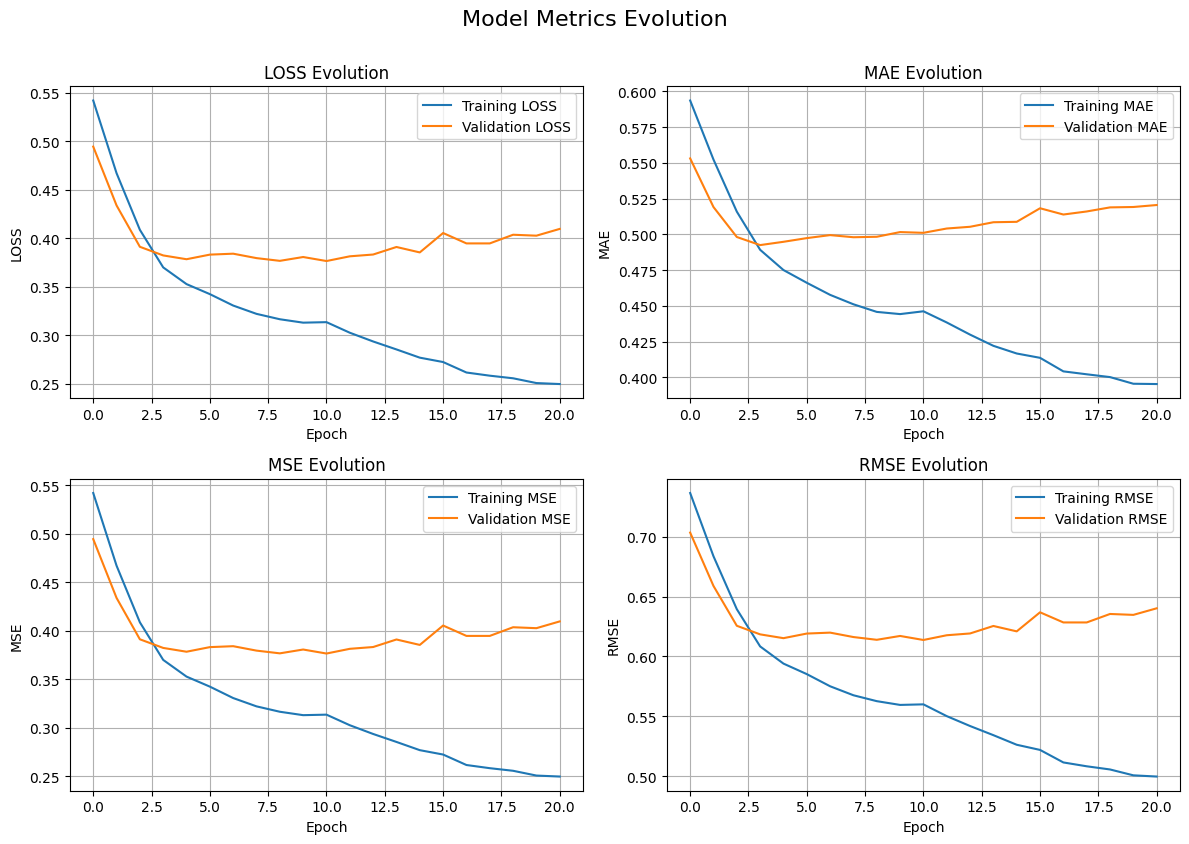

In [220]:
plot_metrics(history_seq)

Loss Evolution : Training Loss gradually declining, that means the model is increasingly getting better in learning the training data. While Validation loss have a slight decrease at start but later stabilize. MAE Evolution : Training MAE consistently decline while Validation MAE only decline at the start and remains stagnant. MSE and RMSE has almost identical output as the MAE graph. This means : at first the data is good at learning the data, but after a few epoch the model doesn't get better in validation data. This may be a cause of a light overfitting which concluded that the model is mainly focused on the training data.



### Functional Model

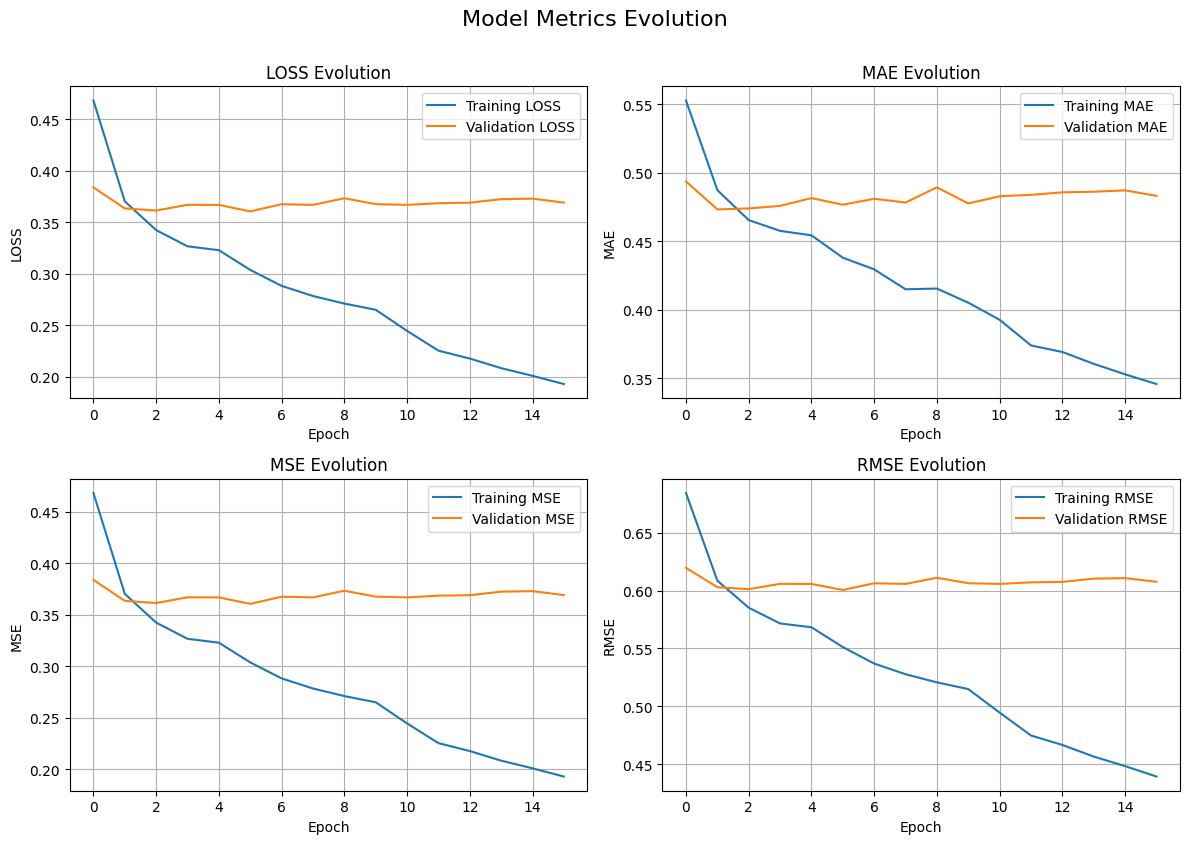

In [221]:
plot_metrics(history_func)

The Graph from functional model is identical to the one in sequential model which has Training Loss gradually decreasing while Validation loss is stable. This implies to all other metrics in the graph (MSE,MAE,RMSE). Which also means that this model is probably slightly overfit

### Modified Sequential Model

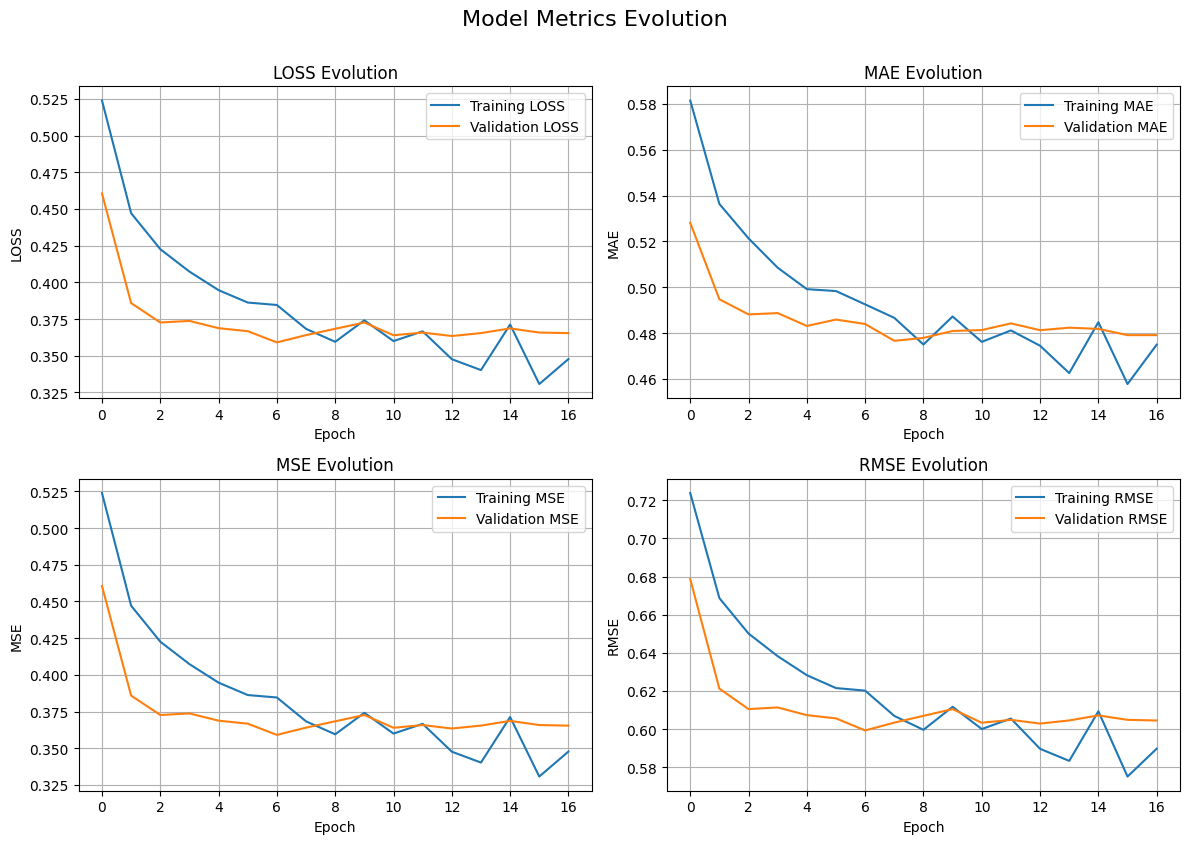

In [222]:
plot_metrics(history_seq_mod)

In this model, the validation loss is declining and in some epoch is lower than the training loss. This implies to all other metrics (RMSE,MSE,and MAE). By looking at the validation metrics is sometimes better than traing metrics, we can conclude that the Modified Sequential Model doesnt overfit nor underfit. Which means this model is pretty good!

### Modified Functional Model

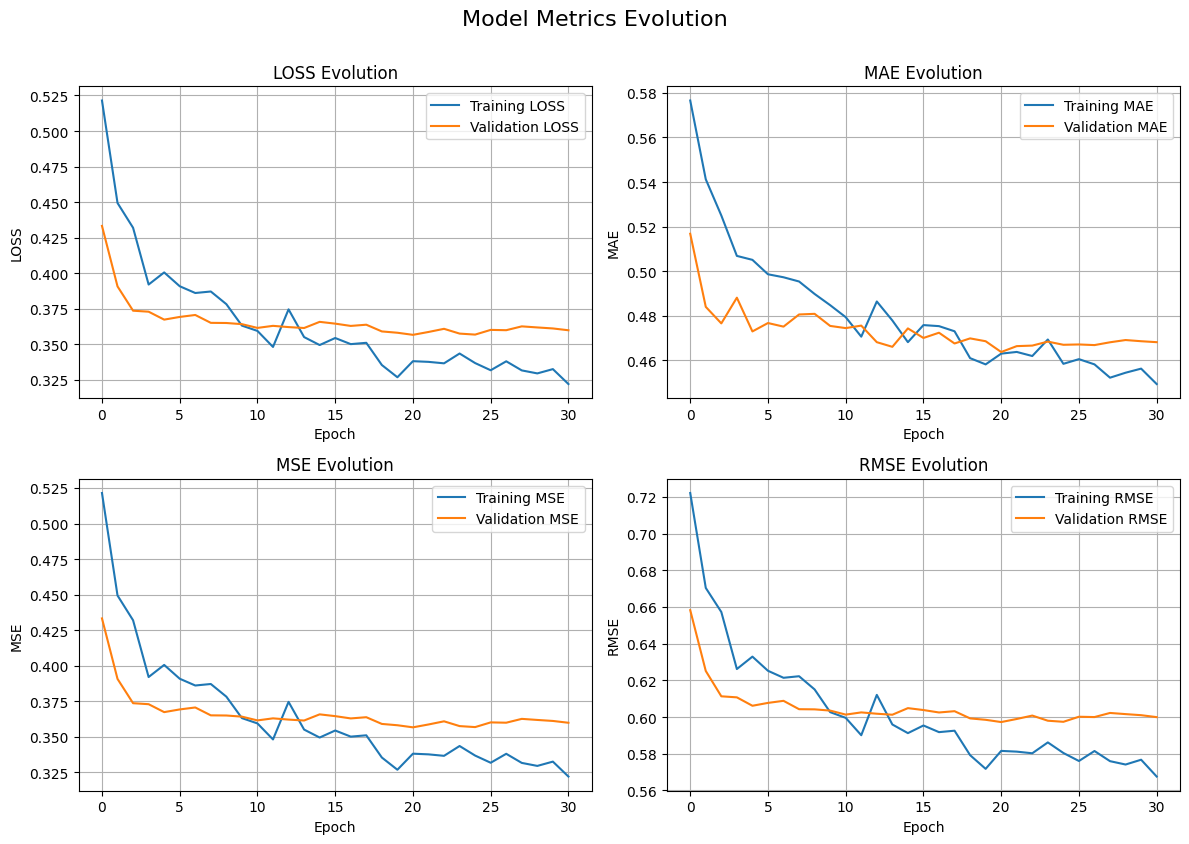

In [223]:
plot_metrics(history_func_mod)

In this Modified Functional Model also have simillar graph output which shows that validation is sometimes lower than the training in some epoch. WHich also means that this model doesnt overfit and underfit. This model is also pretty good!

### Compare All Model

In [224]:
def evaluate_model(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


In [225]:
models= {
  'Sequential': seq_model,
  'Functional': func_model,
  'Modified Sequential': mod_seq_model,
  'Modified Functional': mod_func_model
}

In [226]:
for name, model in models.items():
  evaluate_model(model, x_test, y_test, name)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Evaluation Metrics for Sequential:
Mean Squared Error (MSE): 0.3965
Root Mean Squared Error (RMSE): 0.6297
Mean Absolute Error (MAE): 0.4968
R-squared (R2) Score: 0.2704
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Evaluation Metrics for Functional:
Mean Squared Error (MSE): 0.3753
Root Mean Squared Error (RMSE): 0.6126
Mean Absolute Error (MAE): 0.4881
R-squared (R2) Score: 0.3094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation Metrics for Modified Sequential:
Mean Squared Error (MSE): 0.3849
Root Mean Squared Error (RMSE): 0.6204
Mean Absolute Error (MAE): 0.4938
R-squared (R2) Score: 0.2918
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Evaluation Metrics for Modified Functional:
Mean Squared Error (MSE): 0.3762
Root Mean Squared Error (RMSE): 0.6134
Mean Absolute Error (MAE): 0.4876
R-squared (R2) Score: 0.3077


Now to compare which model is better and which is worse we take a look at the R2 score.

Sequential : 0.2704
Functional : 0.3094
Modified Sequential : 0.2918
Modified Functional : 0.3077


There is an increase in r2 score for the sequential model from 0.2704 to 0.2918. But there is a tiny bit of decrease for functional model from 0.3094 to 0.3077. 
 By looking at the evaluation metrics above, we can see that Functional Non Modified model has the highest R2 score. But this doesnt means this model is the best, because in the graph evolution above, we can clearly see that this model is slightly overfit. Therefore the best model is Modified Functional Model with 0.3077 R2 score and coming slightly short after is Modified Sequential Model.